# Solution for the Kaggle's Competition "Feedback Prize - Predicting Effective Arguments"

Solution for the Kaggle competition "Feedback Prize - Predicting Effective Arguments - Rate the effectiveness of argumentative writing elements from students grade 6-12". The goal of this competition is to classify argumentative elements in student writing as "effective", "adequate" or "ineffective" creating a model using data that is representative of the 6th-12th grade population in the United States. The purpose is to provide students enhanced feedback on their argumentative writing with automated guidance using machine learning.

For this competition I will use a Long Short Term Memory network (LSTM) so we can consider all the sequence of data to make the classifications.

### Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to C:\Users\rd-
[nltk_data]     co\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\rd-
[nltk_data]     co\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Loading the training and test datasets

In [4]:
dataset_test = pd.read_csv("test.csv")
dataset_train = pd.read_csv("train.csv")

### Exploring and analysing the training set (EDA - Exploratory Data Analysis)

In [9]:
dataset_train.head(5)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


We can see that the training set has no missing values, since all the columns has 36765 values being strings.

In [10]:
dataset_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


The unique values of "discourse_id" (36765) is differente compared to "discourse_text" (36691), indicating that there are duplicate values (assuming that for each discourse id, there is a unique discourse text associated).

In [11]:
dataset_train.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


Here we can see all the duplicate results with also different "discourse_effectiveness" for a same "discourse_text"

In [14]:
duplicadas_geral = dataset_train[dataset_train.discourse_text.duplicated(keep=False)].sort_values(by="discourse_text")

In [15]:
duplicadas_geral

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
26691,7f9c3500259d,A602D45D22B2,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
27350,d628a6adda3a,ADB68BCD2874,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
25391,781452d9404c,942ECB176B3A,"At the most basic level, the electoral college...",Position,Adequate
28835,6fa171a95540,C2BAF4ADA2CA,"At the most basic level, the electoral college...",Claim,Adequate
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
...,...,...,...,...,...
27033,f6b2d34d9c01,A98E8EFFC8A9,the technology failing,Claim,Adequate
35488,bcdb6e47ede3,AB8EFBD82820,you can help others.,Claim,Ineffective
35493,98510222f9b8,AB8EFBD82820,you can help others.,Claim,Adequate
4788,d068e2c646e8,56C6D97AF40B,you get to see the world,Claim,Adequate


There's a total of 11 duplicated discourse texts with differente "discourse effectiveness". 

In [26]:
duplicadas_analise = duplicadas_geral.groupby(["discourse_type", "discourse_text"]).discourse_effectiveness.nunique().to_frame().sort_values(by="discourse_effectiveness", ascending=False)
duplicadas_analise.columns = ["discourse_effectiveness_nonUnique"]
duplicadas_analise = duplicadas_analise[duplicadas_analise.discourse_effectiveness_nonUnique > 1].reset_index(drop=False)  
duplicadas_analise

,discourse_type,discourse_text,discourse_effectiveness_nonUnique
0,Claim,"opinions,",2
1,Claim,"Second, there could be a tie in the electoral ...",2
2,Claim,The Electoral College is unfair,2
3,Lead,"When people ask for advice, they sometimes tal...",2
4,Claim,Big States,2
5,Position,I would want to keep the Electoral College,2
6,Claim,you can help others.,2
7,Claim,"be creative,",2
8,Position,The author suggest that studying Venus is a wo...,2
9,Position,Seeking multiple opinions can help someone mak...,2


In [27]:
duplicadas_geral_analise = duplicadas_geral[duplicadas_geral.discourse_text.isin(duplicadas_analise.discourse_text)] 
duplicadas_geral_analise.head(10)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
20121,35bf70c4a673,4CA37D113612,Big States,Claim,Ineffective
20842,34b98386dc46,5729D5AE055C,I would want to keep the Electoral College,Position,Effective
28406,98154af4855d,BACC53ECC1FB,I would want to keep the Electoral College,Position,Adequate
11970,cc0dad1234ec,D8013F49DE51,Opponents say that cell phones are good becaus...,Counterclaim,Adequate
6570,dee3f8aec4fc,7742D58270C9,Opponents say that cell phones are good becaus...,Counterclaim,Ineffective
31753,b318a4e3b80e,EE2FC4219F49,"Second, there could be a tie in the electoral ...",Claim,Effective
31757,43848fd5dfb3,EE2FC4219F49,"Second, there could be a tie in the electoral ...",Claim,Adequate
35299,608e1d81f4ed,9627B47C10DE,Seeking multiple opinions can help someone mak...,Position,Effective
34383,3312a23a5480,523EBD9ECA47,Seeking multiple opinions can help someone mak...,Position,Adequate


#### Visualizing some graphs

Text(0, 0.5, 'Count')

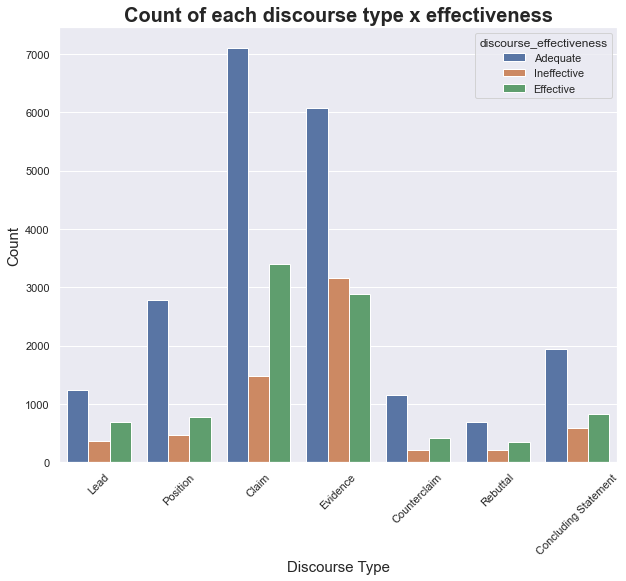

In [28]:
plt.figure(figsize=(10, 8))   # Contagem de cada classe de discurso das redações e as notas correspondentes
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_type", hue="discourse_effectiveness", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse type x effectiveness", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

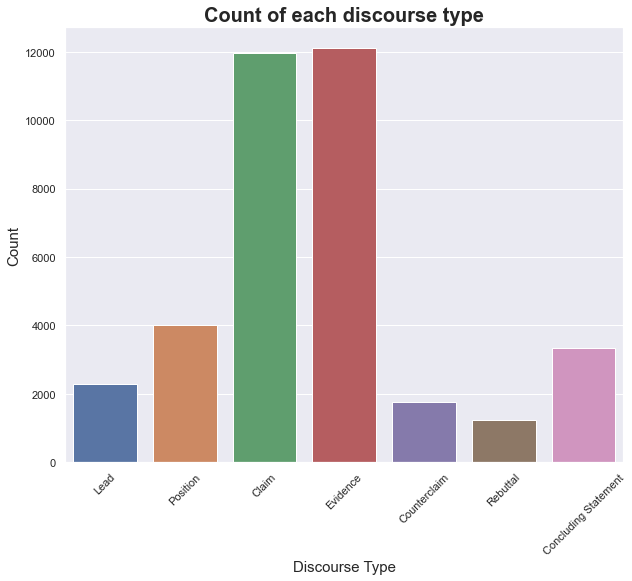

In [29]:
plt.figure(figsize=(10, 8))   # Contagem de cada classe de discurso das redações
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_type", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse type", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

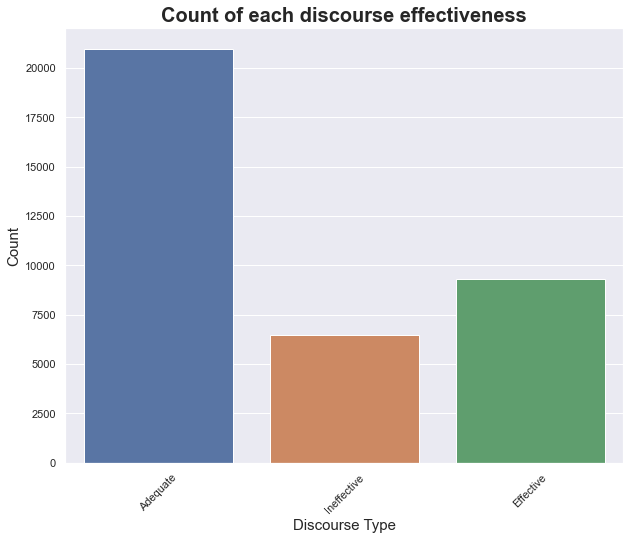

In [30]:
plt.figure(figsize=(10, 8))   # 
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_effectiveness", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse effectiveness", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

We can see that, on average, each essay has approximately 9 "discourse_text":

In [36]:
discType_essayID = dataset_train.groupby(["essay_id"]).discourse_type.value_counts().to_frame()   # Contagem de "discourse_type" no training set para as "essay_id"
discType_essayID.columns = ["Contagem"]
discType_essayID.reset_index(drop=False, inplace=True)
discType_essayID = discType_essayID.pivot(index="essay_id", columns="discourse_type").Contagem

discType_essayID["Total_Sum"] = discType_essayID.sum(axis=1)  # Cria uma nova coluna com a soma de cada count do discourse type em cada linha
discType_essayID

discourse_type,Claim,Concluding Statement,Counterclaim,Evidence,Lead,Position,Rebuttal,Total_Sum
essay_id,,,,,,,,
00066EA9880D,3.0,1.0,NaN,3.0,1.0,1.0,NaN,9.0
000E6DE9E817,5.0,1.0,1.0,3.0,NaN,1.0,1.0,12.0
0016926B079C,7.0,NaN,NaN,3.0,NaN,1.0,NaN,11.0
00203C45FC55,1.0,1.0,3.0,3.0,1.0,1.0,3.0,13.0
0029F4D19C3F,2.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0
...,...,...,...,...,...,...,...,...
FFA381E58FC6,2.0,1.0,NaN,1.0,NaN,1.0,NaN,5.0
FFC43F453EF6,4.0,1.0,3.0,1.0,NaN,1.0,1.0,11.0
FFD97A99CEBA,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0


In [35]:
discType_essayID.Total_Sum.mean()

8.772369362920545

Analyzing the words, chars and sentences counts to see the relationship with the quality rating: 

In [6]:
dataset_train["discourse_text_numChars"] = dataset_train.discourse_text.apply(lambda x: len(x))
dataset_train["discourse_text_numWords"] = dataset_train.discourse_text.apply(lambda x: len(x.split()))
dataset_train["discourse_text_numSentences"] = dataset_train.discourse_text.apply(lambda x: len(tokenize.sent_tokenize(x, language="english")))    # Return a sentence-tokenized copy of text (split text into sentences)

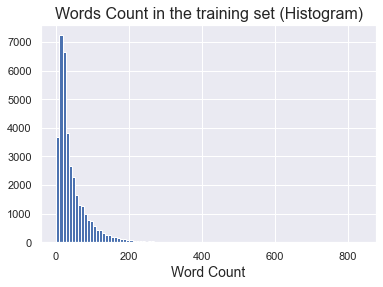

In [38]:
plt.hist(dataset_train["discourse_text_numWords"], bins=100)
plt.title("Words Count in the training set (Histogram)", size = 16)
plt.xlabel("Word Count", size = 14)
plt.show()

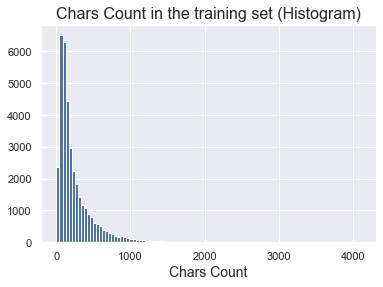

In [39]:
plt.hist(dataset_train["discourse_text_numChars"], bins=100)
plt.title("Chars Count in the training set (Histogram)", size = 16)
plt.xlabel("Chars Count", size = 14)
plt.show()

Text(0.5, 0, 'Word Count')

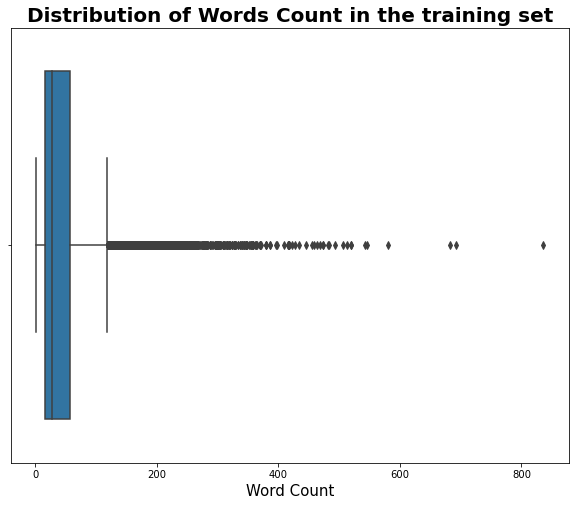

In [9]:
plt.figure(figsize=(10, 8))   
ax = sns.boxplot(x=dataset_train["discourse_text_numWords"])
ax.set_title("Distribution of Words Count in the training set", fontsize=20, weight='bold')
plt.xlabel("Word Count", fontsize=15)

It's possible to see that higher word counts tend to have better quality ratings:

Text(0, 0.5, 'Word Count')

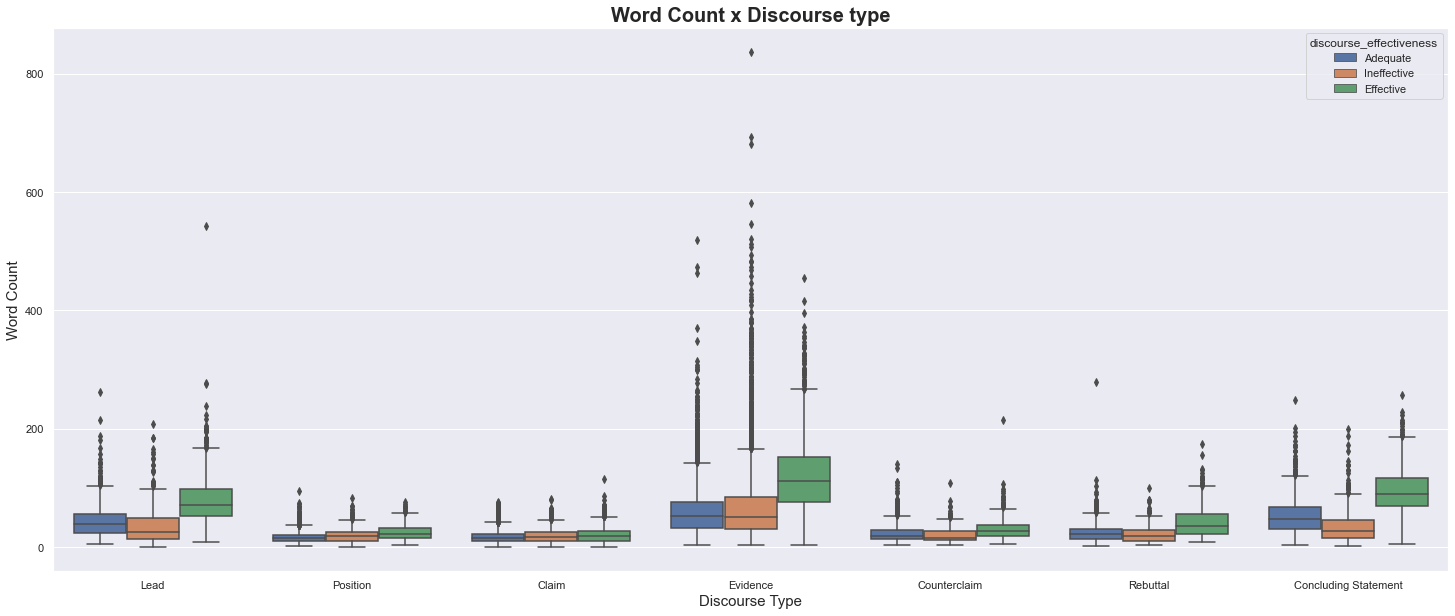

In [40]:
plt.figure(figsize=(25, 10))   
ax = sns.boxplot(x="discourse_type", y="discourse_text_numWords", hue="discourse_effectiveness", data=dataset_train)
#ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Word Count x Discourse type", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Word Count", fontsize=15)

### Normalizing and tokenizing data to remove stopwords, lemmatization, removing special characters, etc.

In [10]:
import text_normalizer as tn
import model_evaluation_utils as meu

Encoding the "discourse_effectiveness" to numbers as it will be our output (prediction class labels):

In [11]:
dataset_train["discourse_effectiveness_encode"] = dataset_train.discourse_effectiveness.replace({"Ineffective": 0, "Adequate":1, "Effective": 2})

Concatenating the "discourse_type" with the "discourse_text" for the training and test set for our input (by concatenating, the algorithm will learn the features of discourse_text presented in each discourse_type)

In [15]:
dataset_train["inputs"] = dataset_train.discourse_type + " " + dataset_train.discourse_text
dataset_test["inputs"] = dataset_test.discourse_type + " " + dataset_test.discourse_text

In [16]:
dataset_train.head(3)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,discourse_text_numChars,discourse_text_numWords,discourse_text_numSentences,discourse_effectiveness_encode,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,317,67,3,1,"Lead Hi, i'm Isaac, i'm going to be writing ab..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,210,41,2,1,"Position On my perspective, I think that the f..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,105,21,1,1,Claim I think that the face is a natural landf...


Passing the dataframes to Numpy arrays:

In [ ]:
train_inputs = np.array(dataset_train["inputs"])
test_inputs = np.array(dataset_test["inputs"])